# Removing MR-related artifact from electrocardiogram data
Acquired during either a single-echo, simultaneous multislice EPI scan or a multi-echo, simultaneous multislice EPI scan collected while participants performed tasks in a 3T Siemens scanner.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter


from glob import glob
import scipy.signal as signal
from scipy.signal import resample

import heartpy as hp
from systole.plots import plot_raw
from systole.detection import interpolate_clipping, ecg_peaks
from systole.utils import heart_rate

In [2]:
import scipy
print('SciPy version', scipy.__version__)

import numpy
print('Numpy version', numpy.__version__)

import pandas
print('Pandas version', pandas.__version__)

import sys 
print("Python version", sys.version) 

SciPy version 1.9.1
Numpy version 1.20.3
Pandas version 1.3.5
Python version 3.8.9 (default, Jul 19 2021, 09:37:30) 
[Clang 13.0.0 (clang-1300.0.27.3)]


Creating color palette...

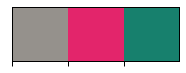

In [3]:
sns.set_context('paper', font_scale=3)

pal = sns.crayon_palette(['Gray', 'Razzmatazz', "Tropical Rain Forest"])
sns.set_palette(pal)
sns.palplot(pal)

## Here, we use `scipy.signal` functions to assemble various digital filters

In [4]:
pd.options.mode.chained_assignment = None

def consecutive(data, stepsize=0.000501):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def comb_band_stop(notch, filtered, Q, fs):
    nyquist = fs / 2
    max_harmonic = int(nyquist/notch)
    min_harmonic = 1
    for i in np.arange(1, max_harmonic):
        #print(notch * i)
        f0 = notch * i
        w0 = f0/nyquist
        b,a = signal.iirnotch(w0, Q)
        filtered = signal.filtfilt(b, a, filtered)
    j = 1
    while (notch / j) > 1:
        #print(notch * i)
        f0 = notch / i
        w0 = f0/nyquist
        b,a = signal.iirnotch(w0, Q)
        filtered = signal.filtfilt(b, a, filtered)
        j += 1
    return filtered

def fourier_freq(timeseries, d, fmax):
    fft = np.fft.fft(timeseries)
    freq = np.fft.fftfreq(timeseries.shape[-1], d=d)
    fft_db = 10 * np.log10(abs(fft))
    limit = np.where(freq >= fmax)[0][0]
    return fft, fft_db, freq, limit

## And `matplotlib.pyplot` to create a signal plotting function

In [5]:
def plot_signal_fourier(time, data, downsample, limits, fft, freq, lim_fmax, 
                        annotate=False, peaks=None, slice_peaks=None, title=None, save=True):
    gridkw = dict(width_ratios=[2,1])
    fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,5))
    plt.tight_layout(pad=1.5)

    sns.lineplot(signal.decimate(time, downsample)[limits[0]:limits[1]], 
                 signal.decimate(data, downsample)[limits[0]:limits[1]], 
                 linewidth=1, ax=ax1) #array, top subplot
    sns.lineplot(freq[:lim_fmax], 
                 fft.real[:lim_fmax], 
                 ax=ax2, linewidth=1)#bottom subplot
    if annotate:
        ax2.plot(freq[peaks][:50], fft.real[peaks][:50], "^", ms=5)
        ax2.plot(freq[slice_peaks][:4], fft.real[slice_peaks][:4], "o", ms=7)
    else:
        pass
    ax1.set_xlabel('seconds')
    ax1.set_ylabel('mV')
    #ax1.set_yticks([-1,0,1,2])
    ax2.set_xlabel('Hz')
    ax2.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
    ax2.set_ylabel('Power')
    ax1.set_title(title, pad=40)
    ax2.set_title('{0} Frequencies'.format(title),pad=40)
    plt.show()
    if save:
        fig.savefig('../figures/{title}.png'.format(title=title), 
                    dpi=400, 
                    bbox_inches='tight')
    else:
        pass

# Electrocardiogram data
## Single-band, single-echo EPI sequence: the Mather dataset
The SBSE sequence used here was used in a study of older and younger adults by Mather et al. (2017), available on <a href="https://doi.org/10.18112/openneuro.ds001242.v1.0.0">OpenNeuro.org</a> (N = 52: 26 younger (i.e., aged 13-34 years; 9 female), and 26 older (i.e., aged 55-75 years; 9 female).
* 41 axial slices
* TE = 25ms
* TR = 2000ms
* MB factor = 1 (i.e., single-band)
* Interleaved acquisition

More information about the scan protocols is available on OpenNeuro.org and in the associated manuscripts (Mather et al., 2017; Lee et al., 2018; Yoo et al., 2018). Participants in this study completed one run of a fear conditioning task and five runs of a spatial conditioning task.

In [6]:
#from Mather dataset sequence
slices = 41
tr = 2.
mb = 1
cutoff = 120

fs = 10000.

nyquist = fs/2
Q = 10

In [7]:
data_fname = '../data/raw/sbse-raw.tsv'
timeseries = pd.read_table(data_fname, header=None, index_col=None)
timeseries.columns = ["cardiac", "respiration", "scr","trigger", "marker"]
timeseries['seconds'] = timeseries.index / fs
basename = data_fname.split('/')[-1][:-4]

if not os.path.exists('../figures'):
    os.mkdir('../figures')

### Step 1A. ECG recording in presence of MR sequence
Then, for the purposes of example ECG data collected during the an fMRI scan was Fourier transformed to identify the frequencies of MR-related artifacts.

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


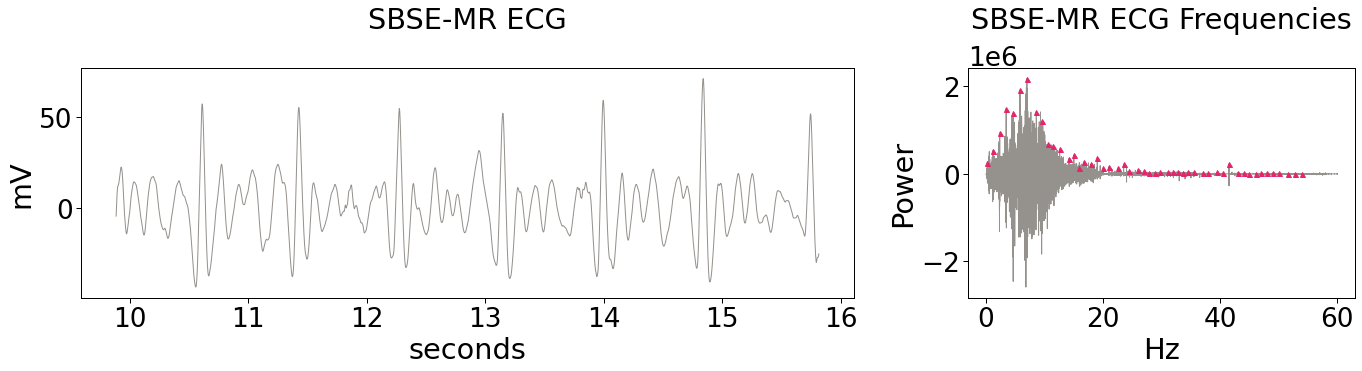

In [8]:
fft_ecg, _, freq, limit = fourier_freq(timeseries['cardiac'].values, 1 / fs, 60)

#find and plot frequencies with highest power  (indicative of MR artifacts)
peaks, _ = signal.find_peaks(fft_ecg.real[:30000], distance=300)
slice_peaks = []
slice_freq = slices / tr
for peak in peaks:
    remainder = np.round(freq[peak],2) % np.round(slice_freq, 2)
    #print(freq[peak], slice_freq, remainder)
    if np.isclose(remainder, 0, atol=1e-2) or np.isclose(remainder, slice_freq, atol=1e-1):
        slice_peaks.append(peak)

plot_signal_fourier(time=timeseries['seconds'], 
                    data=timeseries['cardiac'].values, 
                    downsample=10, 
                    limits=(10000,16000), 
                    fft=fft_ecg, 
                    freq=freq, 
                    lim_fmax=limit, 
                    annotate=True,
                    peaks=peaks,
                    slice_peaks=slice_peaks,
                    title='SBSE-MR ECG', 
                    save=True)

### Step 2A. Manufacturer-recommended filtering of ECG recording in presence of MR sequence
<a href="www.biopac.com">BIOPAC Systems, Inc.</a>, one of the few manufacturers of MR-compatible equipment for collecting electrophysiological data, includes in their Application Notes a recommendation for removing MR-related artifacts from concurrently collected electrophysiological data. While their MR-specific amplifiers catch much of the noise induced by the MR environment, sequence-specific filtering is required to remove the rest. Their recommendations (devised from data collected during single-band, single-echo fMRI sequences) suggest applying a comb band-stop filter centered at the slice collection frequence (calculated as # slices divided by the TR in seconds) and its harmonics up to the Nyquist frequency. We have applied an equivalent filter here to test this approach's efficacy at removing MR-related artifacts from data collected during a multiband, single-echo fMRI sequence.

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


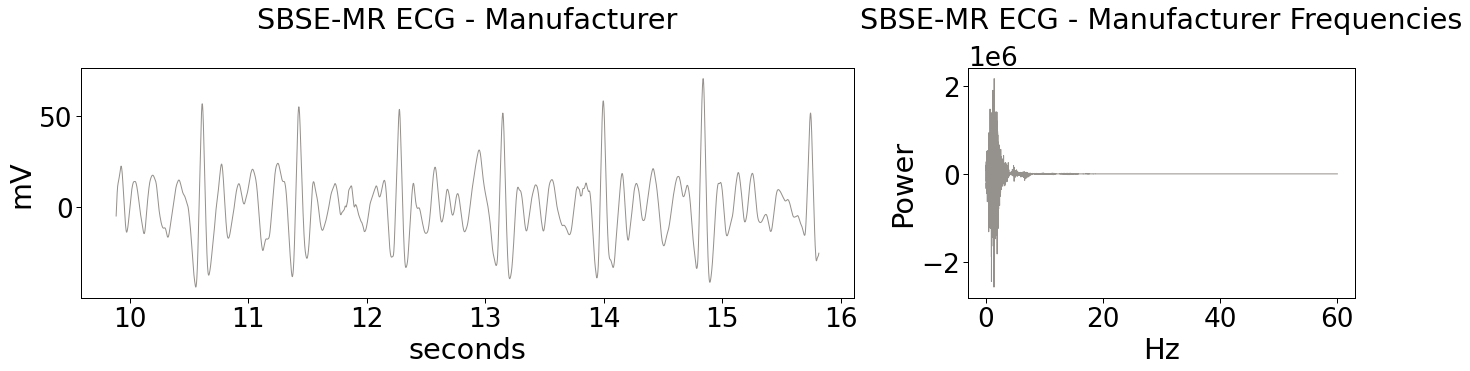

In [9]:
#calculate the slice frequency and apply the filter
notch = slices / tr
biopac_filtered = comb_band_stop(notch, timeseries['cardiac'], Q, fs)

# apply Fourier transform to inspect frequency spectrum
fft_ecg_bp, _, freq, limit = fourier_freq(biopac_filtered, 0.0005, 60)

# plot the cleaned timeseries and frequency spectrum
plot_signal_fourier(time=timeseries['seconds'], 
                    data=biopac_filtered, 
                    downsample=10, 
                    limits=(10000,16000), 
                    fft=fft_ecg_bp, 
                    freq=freq, 
                    lim_fmax=limit, 
                    annotate=False,
                    peaks=None,
                    slice_peaks=None,
                    title='SBSE-MR ECG - Manufacturer', 
                    save=True)

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


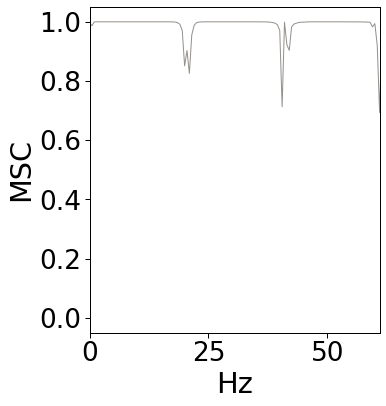

In [10]:
f, Cxy = signal.coherence(timeseries['cardiac'], biopac_filtered, fs=fs, nperseg=fs * 2)

fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.set_ylabel('MSC')
ax.set_xlim(0,61)
#ax.set_xticks([0,10,20,30,40,50])
plt.show()
fig.savefig('../figures/{0}-ecgRawXecgBIOPACClean.svg'.format(basename))

## Multiband, single-echo EPI sequence
The MBSE sequence used here is the one used by the Adolescent Brain Cognitive Development (ABCD)℠ Study (Casey et al., 2018). 
* 60 transverse slices, with an anterior to posterior phase encoding direction
* TE = 30ms
* TR = 800ms
* MB factor = 6
* Interleaved acquisition

More information about the scan protocols is available with the curated ABCD data via the <a href="https://abcdstudy.org/scientists/protocols/">NIMH Data Archive</a> (NDA)). Participants in the current study (n=2, male, aged 9) completed four 6-minute runs of an emotion regulation task (Blair et al., 2012; Ochsner et al., 2002, 2004) and two 5-minute runs of rest.

In [11]:
#from ABCD sequence
slices = 60
tr = 0.8
mb = 6
cutoff = 120

fs = 2000.

nyquist = fs/2


In [12]:
data_fname = '../data/raw/mbse-raw.csv'
timeseries = pd.read_csv(data_fname, header=0, index_col=None)
basename = data_fname.split('/')[-1][:-4]

if not os.path.exists('../figures'):
    os.mkdir('../figures')

### Step 0. ECG recording in absence of MR sequence
First, Fourier transform was applied to ECG and EDA data collected both in the presence (`Trigger == 5`) and absence (`Trigger != 5`) of MR pulse sequences to identify the frequencies of MR-related artifacts.

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


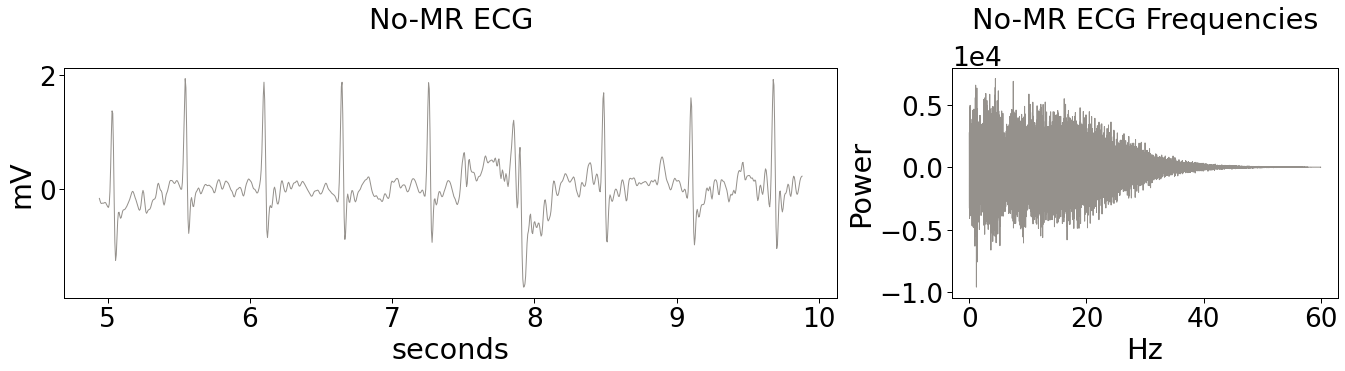

In [13]:
fft_ecg, _, freq, limit = fourier_freq(timeseries[timeseries['Trigger'] != 5]['ECG'][:1000000], 0.0005, 60)
plot_signal_fourier(time=timeseries['seconds'][:200000], 
                    data=timeseries['ECG'][:200000], 
                    downsample=10, 
                    limits=(1000,2000), 
                    fft=fft_ecg, 
                    freq=freq, 
                    lim_fmax=limit, 
                    annotate=False,
                    peaks=None,
                    slice_peaks=None,
                    title='No-MR ECG', 
                    save=True)

### Step 1A. ECG recording in absence of MR sequence
Then, for the purposes of example ECG data collected during the first fMRI scan (`Trigger == 5`) was isolated and Fourier transform was applied to identify the frequencies of MR-related artifacts.

In [14]:
scan1 = timeseries[timeseries['scan'] == 1]


/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


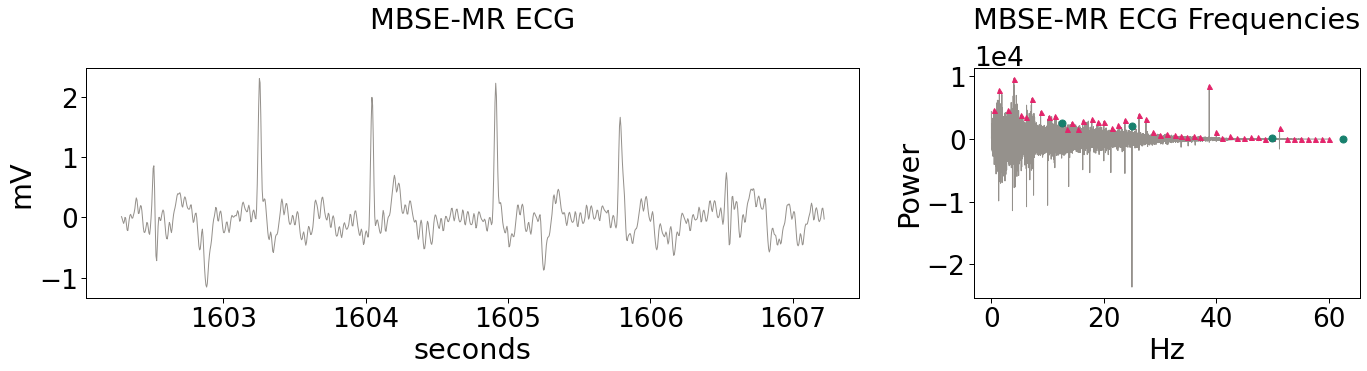

In [15]:
fft_ecg, _, freq, limit = fourier_freq(scan1['ECG'].values, 0.0005, 60)

#find and plot frequencies with highest power  (indicative of MR artifacts)
peaks, _ = signal.find_peaks(fft_ecg.real[:30000], distance=300)
slice_peaks = []
slice_freq = slices / mb / tr
for peak in peaks:
    remainder = np.round(freq[peak],2) % np.round(slice_freq, 2)
    #print(freq[peak], slice_freq, remainder)
    if np.isclose(remainder, 0, atol=1e-2) or np.isclose(remainder, slice_freq, atol=1e-1):
        slice_peaks.append(peak)

plot_signal_fourier(time=scan1['seconds'], 
                    data=scan1['ECG'].values, 
                    downsample=10, 
                    limits=(1000,2000), 
                    fft=fft_ecg, 
                    freq=freq, 
                    lim_fmax=limit, 
                    annotate=True,
                    peaks=peaks,
                    slice_peaks=slice_peaks,
                    title='MBSE-MR ECG', 
                    save=True)

### Step 1B. Magnitude squared coherence between ECG recordings in presence and absence of MR sequence
Physiological data were compared across steps and to data collected in the absence of MR pulse sequences, using magnitude squared coherence to assess linear dependence across the frequency band in which physiologically-relevant signals were found:  0.5 - 50Hz for ECG and <0.5Hz for EDA.

In [16]:
f, Cxy = signal.coherence(scan1['ECG'], 
                          timeseries[timeseries['Trigger'] != 5]['ECG'], 
                          fs=fs, nperseg=fs * 4)

And here's a plot of the frequency bands with biologically relevant cardiac data from ECG.

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


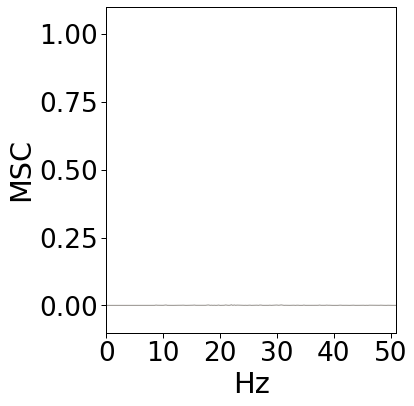

In [17]:
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1, )
ax.set_xlabel('Hz')
ax.set_ylabel('MSC')
ax.set_xlim(0,51)
ax.set_ylim(-0.1, 1.1)
ax.set_xticks([0,10,20,30,40,50])
plt.show()
fig.savefig('../figures/{0}-scan1-ecgNoMRIXecgRaw.svg'.format(basename))

### Step 2A. Manufacturer-recommended filtering of ECG recording in presence of MR sequence
<a href="www.biopac.com">BIOPAC Systems, Inc.</a>, one of the few manufacturers of MR-compatible equipment for collecting electrophysiological data, includes in their Application Notes a recommendation for removing MR-related artifacts from concurrently collected electrophysiological data. While their MR-specific amplifiers catch much of the noise induced by the MR environment, sequence-specific filtering is required to remove the rest. Their recommendations (devised from data collected during single-band, single-echo fMRI sequences) suggest applying a comb band-stop filter centered at the slice collection frequence (calculated as # slices divided by the TR in seconds) and its harmonics up to the Nyquist frequency. We have applied an equivalent filter here to test this approach's efficacy at removing MR-related artifacts from data collected during a multiband, single-echo fMRI sequence.

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


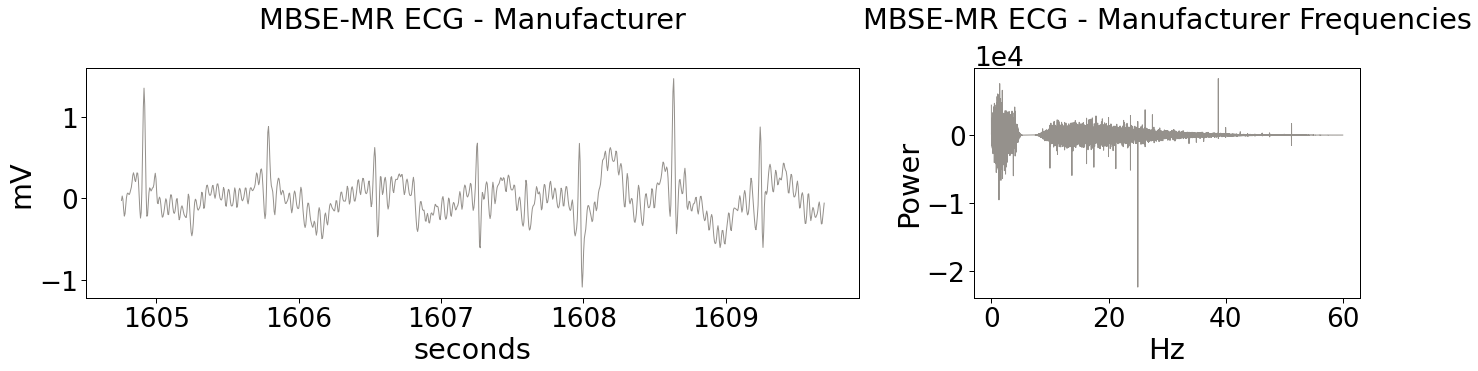

In [18]:
#calculate the slice frequency and apply the filter
notch = slices / tr
biopac_filtered = comb_band_stop(notch, scan1['ECG'], Q, fs)

# apply Fourier transform to inspect frequency spectrum
fft_ecg_bp, _, freq, limit = fourier_freq(biopac_filtered, 0.0005, 60)

# plot the cleaned timeseries and frequency spectrum
plot_signal_fourier(time=scan1['seconds'], 
                    data=biopac_filtered, 
                    downsample=10, 
                    limits=(1500,2500), 
                    fft=fft_ecg_bp, 
                    freq=freq, 
                    lim_fmax=limit, 
                    annotate=False,
                    peaks=None,
                    slice_peaks=None,
                    title='MBSE-MR ECG - Manufacturer', 
                    save=True)

### Step 2B. Magnitude squared coherence between ECG recordings in presence (raw and cleaned) and absence of MR sequence
Physiological data were compared across steps and to data collected in the absence of MR pulse sequences, using magnitude squared coherence to assess linear dependence across the frequency band in which physiologically-relevant signals were found:  0.5 - 50Hz for ECG and <0.5Hz for EDA.

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


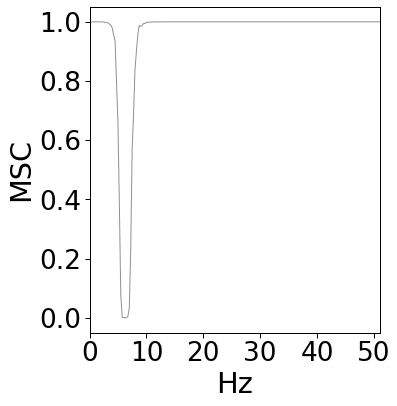

In [19]:
f, Cxy = signal.coherence(scan1['ECG'], biopac_filtered, fs=fs, nperseg=fs * 4)

fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.set_ylabel('MSC')
ax.set_xlim(0,51)
ax.set_xticks([0,10,20,30,40,50])
plt.show()
fig.savefig('../figures/{0}-ecgRawXecgBIOPACClean.svg'.format(basename))

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


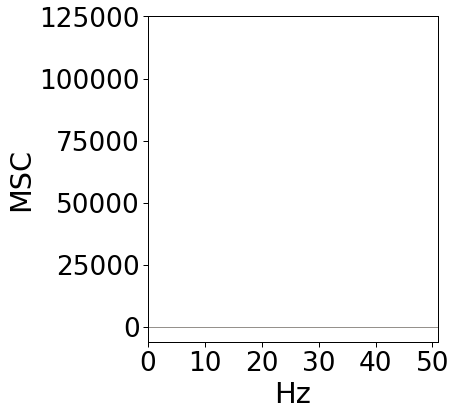

In [20]:
f, Cxy = signal.coherence(timeseries[timeseries['Trigger'] != 5]['ECG'], biopac_filtered, fs=fs, nperseg=fs * 4)
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.set_ylabel('MSC')
ax.set_xlim(0,51)
ax.set_xticks([0,10,20,30,40,50])
plt.show()
fig.savefig('../figures/{0}-ecgNoMRIXecgBIOPACClean.svg'.format(basename))

### Step 3A. Update filtering to account for multiband factor and apply to ECG recordings collected during multiband, single-echo EPI sequence.
Based on the identified artifact frequencies, we then adjusted these recommendations to account for the multiband factor of each sequence, with IIR notch filters centered at the frequency corresponding to the number of slices divided by the multiband factor per TR (again, including harmonics) and applied the resultant filter to ECG recordings collected concurrently with multiband, single-echo fMRI sequence.

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


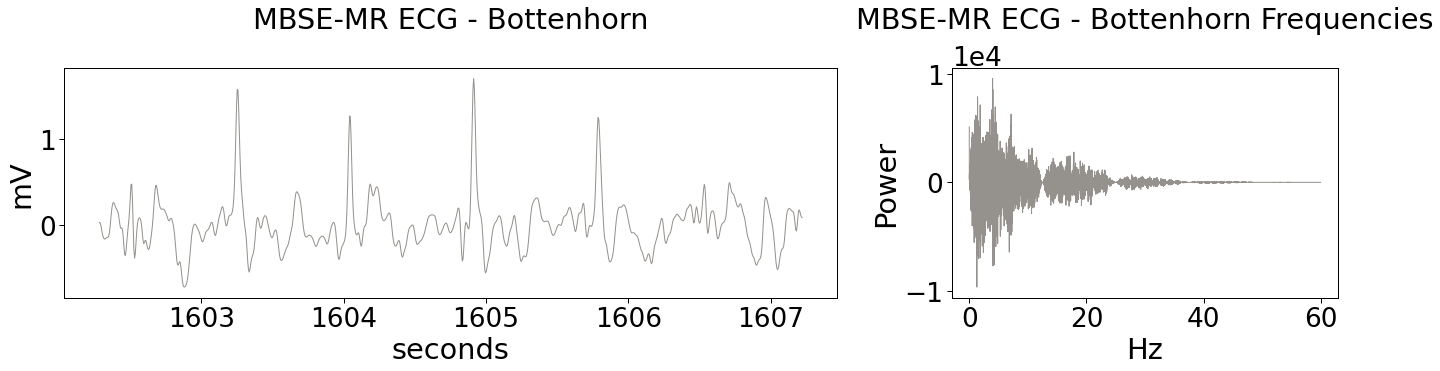

In [21]:
#calculate multiband-updated slice frequency and apply it with a notch filter
notches = {'slices': slices / mb / tr, 
           'tr': 1 / tr}
Qs = {'slices': 10, 'tr': 100}

bottenhorn_filtered = scan1['ECG']
for notch in notches:
    bottenhorn_filtered = comb_band_stop(notches[notch], bottenhorn_filtered, Qs[notch], fs)

# apply Fourier transform to inspect frequency spectrum
fft_ecg_bt, _, freq, limit = fourier_freq(bottenhorn_filtered, 0.0005, 60)

# plot the cleaned timeseries and frequency spectrum
plot_signal_fourier(time=scan1['seconds'], 
                    data=bottenhorn_filtered, 
                    downsample=10, 
                    limits=(1000,2000), 
                    fft=fft_ecg_bt, 
                    freq=freq, 
                    lim_fmax=limit, 
                    annotate=False,
                    peaks=None,
                    slice_peaks=None,
                    title='MBSE-MR ECG - Bottenhorn', 
                    save=True)

### Step 3B. Magnitude squared coherence between ECG recordings in presence (raw and cleaned) and absence of multiband, single-echo EPI sequence
Physiological data were compared across steps and to data collected in the absence of MR pulse sequences, using magnitude squared coherence to assess linear dependence across the frequency band in which physiologically-relevant signals were found:  0.5 - 50Hz for ECG and <0.5Hz for EDA.

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


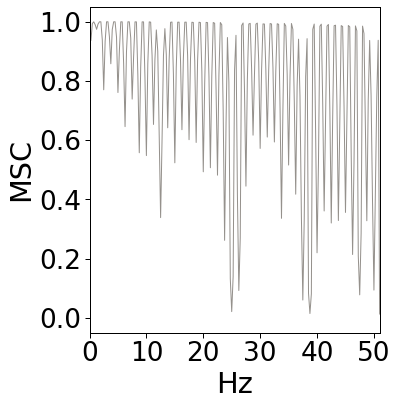

In [22]:
# calculate and plot magnitude squared coherence between raw
# and updated-recommendation-cleaned ECG signals, across cardiovascularly-relevant frequency band

f, Cxy = signal.coherence(scan1['ECG'], bottenhorn_filtered, fs=fs, nperseg=fs * 4)

fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.set_ylabel('MSC')
ax.set_xlim(0,51)
ax.set_xticks([0,10,20,30,40,50])
plt.show()
fig.savefig('../figures/{0}-ecgRawXecgBottenClean.svg'.format(basename))

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


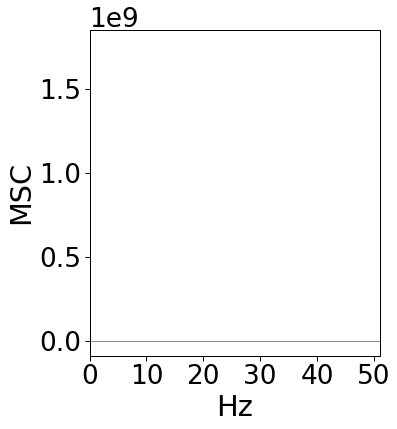

In [23]:
# calculate and plot magnitude squared coherence between no-MR ECG signals
# and updated-recommendation-cleaned ECG signals, across cardiovascularly-relevant frequency band

f, Cxy = signal.coherence(timeseries[timeseries['Trigger'] != 5]['ECG'], bottenhorn_filtered, 
                          fs=fs, nperseg=fs * 4)
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.set_ylabel('MSC')
ax.set_xlim(0,51)
ax.set_xticks([0,10,20,30,40,50])
plt.show()
fig.savefig('../figures/{0}-ecgNoMRIXecgBottenClean.svg'.format(basename))

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


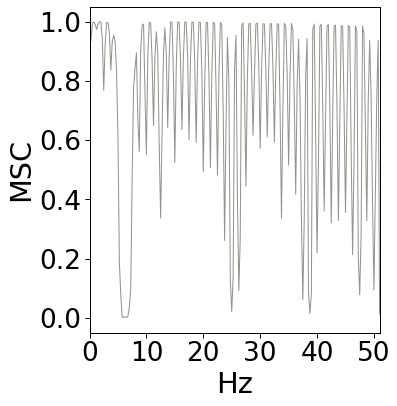

In [24]:
# calculate and plot magnitude squared coherence between manufacturer-recommendation-cleaned
# and updated-recommendation-cleaned ECG signals, across cardiovascularly-relevant frequency band
f, Cxy = signal.coherence(biopac_filtered, bottenhorn_filtered, fs=fs, nperseg=fs * 4)
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.set_ylabel('MSC')
ax.set_xlim(0,51)
ax.set_xticks([0,10,20,30,40,50])
plt.show()
fig.savefig('../figures/{0}-ecgBIOPACCleanXecgBottenClean.svg'.format(basename))

## Multiband, multi-echo EPI sequence
The MBME BOLD EPI sequence used here is from the  distribution of multi-band accelerated EPI sequences (Moeller et al., 2010) developed by the Center for Magnetic Resonance Research at the University of Minnesota:
* 48 slices at a 30º transverse-to-coronal orientation with anterior-to-posterior phase encoding direction
* 4 echoes (TE1 = 11.80ms, TE2 = 28.04ms, TE3 = 44.28ms, TE4 = 60.52ms) 
* TR = 1500ms
* MB factor = 3, interleaved acquisition, in-plane GRAPPA acceleration, a 77º flip angle, and an excite pulse duration of 2560µs. 

Participants (n = 4, female, aged 26-39) completed six runs, 6 to 11 minutes each, of film watching (Duffer & Duffer, 2017; NBCLab/Film-Viewing-Task, 2019/2020), two runs of the same emotion regulation task (NBCLab/Eirt-Task, 2020/2020), two runs of a probabilistic selection task, one 6 minutes and the other 9 minutes (Frank et al., 2004), and two runs of 5 minutes of rest.
The full parameters and fMRI data are available on <a href="https://openneuro.org/datasets/ds002278/versions/1.0.1">OpenNeuro.org</a>. 


In [25]:
#arranging noisy frequencies to be filtered out
slices = 48
tr = 1.5
mb = 3
cutoff = 120

fs = 2000.

nyquist = fs/2

In [26]:
data_fname = '../data/raw/mbme-raw2.tsv.gz'
timeseries = pd.read_table(data_fname)
basename = data_fname.split('/')[-1][:-4]
timeseries.columns = ["time",
        "cardiac",
        "respiration",
        "eda",
        "trigger"]
no_mr = '../data/raw/mbme-noMR.tsv'
no_mr_ts = pd.read_table(no_mr, index_col=0)
no_mr_ts['seconds'] = no_mr_ts.index / fs
timeseries.head()

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,time,cardiac,respiration,eda,trigger
0,-8.9995,0.064087,0.003967,3.086853,0.0
1,-8.9990,0.063782,0.004272,3.088379,0.0
2,-8.9985,0.063477,0.003662,3.085327,0.0
3,-8.9980,0.063171,0.003662,3.085327,0.0
4,-8.9975,0.062561,0.003967,3.086853,0.0


### Step 0. ECG recording in absence of multiband, multi-echo EPI sequence
First, Fourier transform was applied to ECG and EDA data collected both in the presence (`Trigger == 5`) and absence (`Trigger != 5`) of MR pulse sequences to identify the frequencies of MR-related artifacts.

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


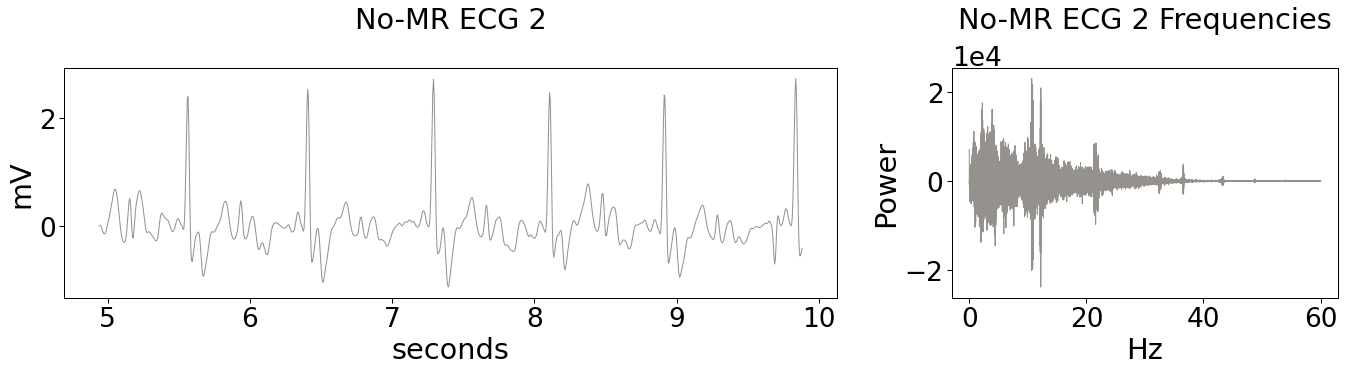

In [27]:
fft_ecg, _, freq, limit = fourier_freq(no_mr_ts['cardiac'], 1/fs, 60)
plot_signal_fourier(time=no_mr_ts['seconds'], 
                    data=no_mr_ts['cardiac'], 
                    downsample=10, 
                    limits=(1000,2000), 
                    fft=fft_ecg, 
                    freq=freq, 
                    lim_fmax=limit, 
                    annotate=False,
                    peaks=None,
                    slice_peaks=None,
                    title='No-MR ECG 2', 
                    save=True)

### Step 1A. ECG recording in absence of multiband, multi-echo EPI sequence
Then, for the purposes of example ECG data collected during the first fMRI scan (`Trigger == 5`) was isolated and Fourier transform was applied to identify the frequencies of MR-related artifacts.

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


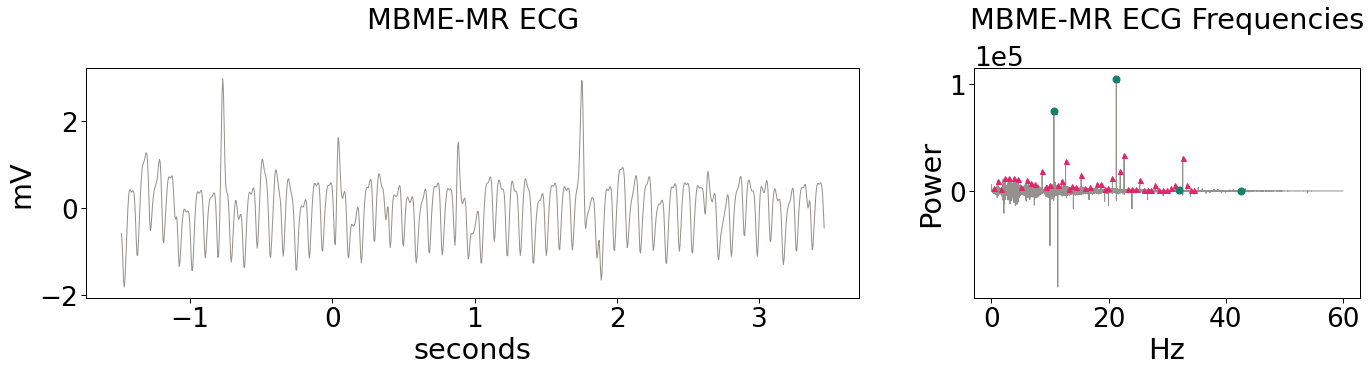

In [28]:
fft_ecg, _, freq, limit = fourier_freq(timeseries['cardiac'].values, 1 / fs, 60)

#find and plot frequencies with highest power  (indicative of MR artifacts)
peaks, _ = signal.find_peaks(fft_ecg.real[:30000], distance=300)
slice_peaks = []
slice_freq = slices / mb / tr
for peak in peaks:
    remainder = np.round(freq[peak],2) % np.round(slice_freq, 2)
    #print(freq[peak], slice_freq, remainder)
    if np.isclose(remainder, 0, atol=1e-2) or np.isclose(remainder, slice_freq, atol=1e-1):
        slice_peaks.append(peak)

plot_signal_fourier(time=timeseries['time'], 
                    data=timeseries['cardiac'].values, 
                    downsample=10, 
                    limits=(1500,2500), 
                    fft=fft_ecg, 
                    freq=freq, 
                    lim_fmax=limit, 
                    annotate=True,
                    peaks=peaks,
                    slice_peaks=slice_peaks,
                    title='MBME-MR ECG', 
                    save=True)

### Step 1B. Magnitude squared coherence between ECG recordings in presence and absence of multiband, multiecho EPI sequence
Physiological data were compared across steps and to data collected in the absence of MR pulse sequences, using magnitude squared coherence to assess linear dependence across the frequency band in which physiologically-relevant signals were found:  0.5 - 50Hz for ECG and <0.5Hz for EDA.

In [29]:
f, Cxy = signal.coherence(timeseries['cardiac'], 
                          no_mr_ts['cardiac'], 
                          fs=fs, nperseg=fs * 4)

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


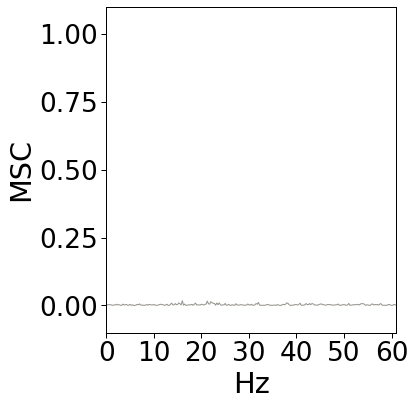

In [30]:
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
ax.set_xlim(0,61)
ax.set_ylim(-0.1, 1.1)
ax.set_xticks([0,10,20,30,40,50,60])
plt.show()
fig.savefig('../figures/{0}-ecgNoMRIXecgRaw.svg'.format(basename))

### Step 2A. Manufacturer-recommended filtering of ECG recording in presence of multiband, multi-echo EPI sequence
<a href="www.biopac.com">BIOPAC Systems, Inc.</a>, one of the few manufacturers of MR-compatible equipment for collecting electrophysiological data, includes in their Application Notes a recommendation for removing MR-related artifacts from concurrently collected electrophysiological data. While their MR-specific amplifiers catch much of the noise induced by the MR environment, sequence-specific filtering is required to remove the rest. Their recommendations (devised from data collected during single-band, single-echo fMRI sequences) suggest applying a comb band-stop filter centered at the slice collection frequence (calculated as # slices divided by the TR in seconds) and its harmonics up to the Nyquist frequency. We have applied an equivalent filter here to test this approach's efficacy at removing MR-related artifacts from data collected during a multiband, multi-echo fMRI sequence.

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


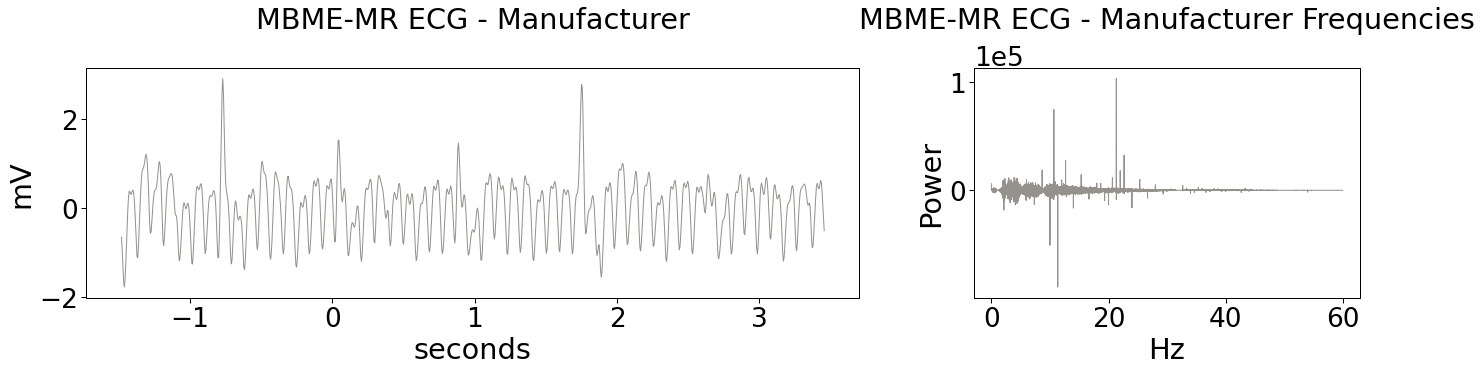

In [31]:
#calculate the slice frequency and apply the filter
notch = slices / tr
Q = 10
biopac_filtered = comb_band_stop(notch, timeseries['cardiac'], Q, fs)

# apply Fourier transform to inspect frequency spectrum
fft_ecg_bp, _, freq, limit = fourier_freq(biopac_filtered, 0.0005, 60)

# plot the cleaned timeseries and frequency spectrum
plot_signal_fourier(time=timeseries['time'], 
                    data=biopac_filtered, 
                    downsample=10, 
                    limits=(1500,2500), 
                    fft=fft_ecg_bp, 
                    freq=freq, 
                    lim_fmax=limit, 
                    annotate=False,
                    peaks=None,
                    slice_peaks=None,
                    title='MBME-MR ECG - Manufacturer', 
                    save=True)

### Step 2B. Magnitude squared coherence between ECG recordings in presence (raw and cleaned) and absence of multiband, multi-echo EPI sequence
Physiological data were compared across steps and to data collected in the absence of MR pulse sequences, using magnitude squared coherence to assess linear dependence across the frequency band in which physiologically-relevant signals were found:  0.5 - 50Hz for ECG and <0.5Hz for EDA.

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


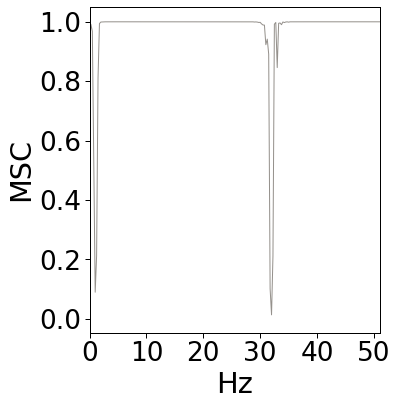

In [32]:
f, Cxy = signal.coherence(timeseries['cardiac'], biopac_filtered, fs=fs, nperseg=fs * 4)

fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
ax.set_xlim(0,51)
ax.set_xticks([0,10,20,30,40,50])
plt.show()
#fig.savefig('../figures/{0}-ecgRawXecgBIOPACClean.svg'.format(basename))

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


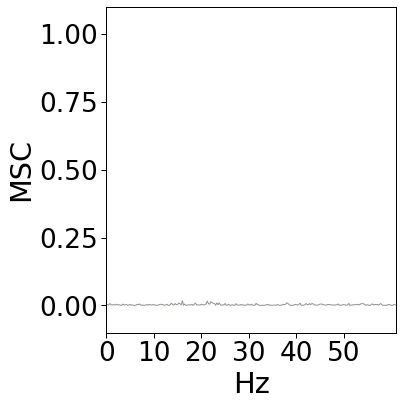

In [33]:
f, Cxy = signal.coherence(no_mr_ts['cardiac'], 
                          biopac_filtered, 
                          fs=fs, nperseg=fs * 4)
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
ax.set_ylim(-0.1,1.1)
ax.set_xlim(0,61)
ax.set_xticks([0,10,20,30,40,50])
plt.show()
fig.savefig('../figures/{0}-ecgNoMRIXecgBIOPACClean.svg'.format(basename))

### Step 3A. Update filtering to account for multiband factor and apply to ECG recordings collected during multiband, multi-echo EPI sequence.
Based on the identified artifact frequencies, we then adjusted these recommendations to account for the multiband factor of each sequence, with IIR notch filters centered at the frequency corresponding to the number of slices divided by the multiband factor per TR (again, including harmonics). Again, we adjusted the slice collection frequency to account for the multiband factor and applied it as a series of notch filters. Furthermore, potentially due to the increased power of the RF pulse required for acquiring multiple echoes, we observed an artifact frequency of markedly greater power to those seen in the ECG data collected concurrently with the single-echo sequence (above) at the TR frequency. To address this additional artifact, we applied the notch filters centered at the TR frequency (and its harmonics up to Nyquist) to ECG recordings collected concurrently with multiband, multi-echo fMRI sequence.

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


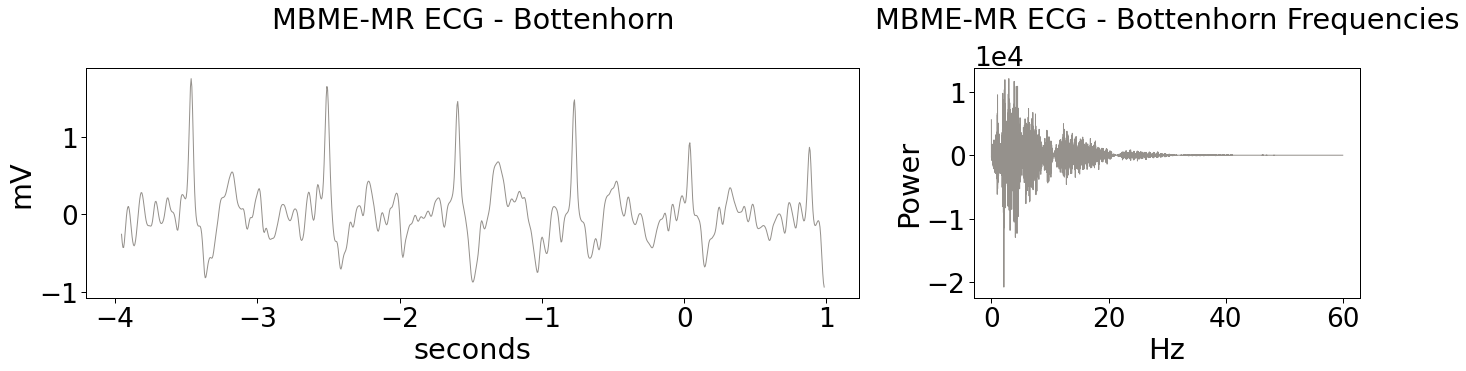

In [34]:
notches = {'slices': slices / mb / tr, 
           'tr': 1 / tr}
Qs = {'slices': 10, 'tr': 100}

#hp_ecg = butter_highpass_filter(scan1['ECG'], 1, fs, order=5)
bottenhorn_filtered = timeseries['cardiac']
for notch in notches:
    bottenhorn_filtered = comb_band_stop(notches[notch], bottenhorn_filtered, Qs[notch], fs)

#calculate the slice frequency and apply the filter

# apply Fourier transform to inspect frequency spectrum
fft_ecg_bt, _, freq, limit = fourier_freq(bottenhorn_filtered, 1/fs, 60)

# plot the cleaned timeseries and frequency spectrum
plot_signal_fourier(time=timeseries['time'], 
                    data=bottenhorn_filtered, 
                    downsample=10, 
                    limits=(1000,2000), 
                    fft=fft_ecg_bt, 
                    freq=freq, 
                    lim_fmax=limit, 
                    annotate=False,
                    title='MBME-MR ECG - Bottenhorn', 
                    save=True)

### Step 3B. Magnitude squared coherence between ECG recordings in presence (raw and cleaned) and absence of multiband, multi-echo EPI sequence
Physiological data were compared across steps and to data collected in the absence of MR pulse sequences, using magnitude squared coherence to assess linear dependence across the frequency band in which physiologically-relevant signals were found:  0.5 - 50Hz for ECG and <0.5Hz for EDA.

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


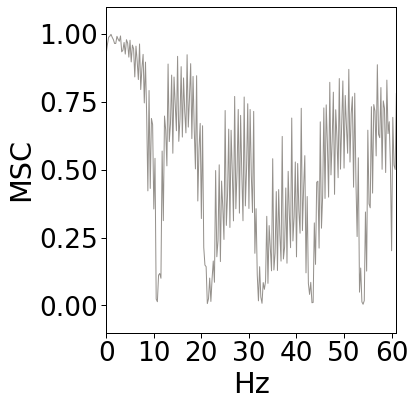

In [35]:
f, Cxy = signal.coherence(timeseries['cardiac'], bottenhorn_filtered, fs=fs, nperseg=fs * 4)

fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
ax.set_xlim(0,61)
ax.set_ylim(-0.1, 1.1)
ax.set_xticks([0,10,20,30,40,50,60])
plt.show()
#fig.savefig('../figures/{0}-ecgRawXecgBottenClean.svg'.format(basename))

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


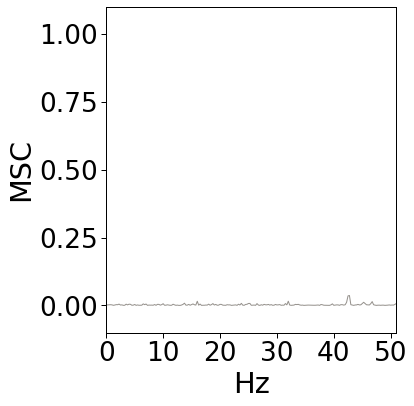

In [36]:
f, Cxy = signal.coherence(no_mr_ts['cardiac'], 
                          bottenhorn_filtered, 
                          fs=fs, nperseg=fs * 4)
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
ax.set_xlim(0,51)
ax.set_ylim(-0.1, 1.1)
ax.set_xticks([0,10,20,30,40,50])
plt.show()
fig.savefig('../figures/{0}-ecgNoMRIXecgBottenClean.svg'.format(basename))

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


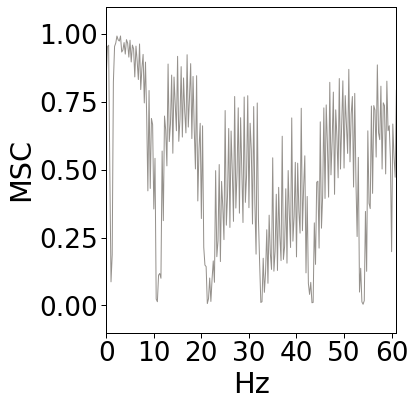

In [37]:
f, Cxy = signal.coherence(biopac_filtered, 
                          bottenhorn_filtered, 
                          fs=fs, nperseg=fs * 4)
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
ax.set_xlim(0,61)
ax.set_ylim(-0.1, 1.1)
ax.set_xticks([0,10,20,30,40,50,60])
plt.show()
#fig.savefig('../figures/{0}-ecgBIOPACCleanXecgBottenClean.svg'.format(basename))

In [38]:
Q

10